In [1]:
using DataFrames
using Chemfiles
using Gadfly
using Cairo
using Compose
set_default_plot_size(40cm, 14cm)

home = "/home/german/labo/18/egfr/modos/"
rehome = "/home/german/labo/18/egfr/renonmis_gram/"
home_rtdos = "/home/german/labo/18/egfr/rtdos_log/"
aa = 277

277

In [2]:
function tognm(vtor_anm)
    vtor_gnm = Array{Float64}(convert(Int64, length(vtor_anm)/3));
    vtor_anm =  vtor_anm.^2
    for i=1:convert(Int64, length(vtor_anm)/3)
        vtor_gnm[i] = sqrt(vtor_anm[i*3-2] + vtor_anm[i*3-1] + vtor_anm[i*3])
    end
    return vtor_gnm
end

tognm (generic function with 1 method)

In [3]:
function WeightedHist(in_vec, in_bins, in_weight, density = false)
    # Safety check    
    if length(in_vec) != length(in_weight)
        println("Each element of the input vector needs one weight")
        return
    end
    
    # Prepare variables
    out_counts = Array{Float64}(length(in_bins)-1)
    
    # Get weighted histogram
    for i=1:length(in_bins)-1
        if i == 1
            # Include those that fall before the beggining of the bins
            temp_bool = (in_vec .>= in_bins[i]) .& (in_vec .< in_bins[i+1]) .| (in_vec .<= in_bins[i])
            out_counts[i] = sum(in_weight[temp_bool])
        elseif i == length(in_bins)-1
            # Include those that fall after the end of the bins
            temp_bool = (in_vec .>= in_bins[i]) .& (in_vec .< in_bins[i+1]) .| (in_vec .>= in_bins[end])
            out_counts[i] = sum(in_weight[temp_bool])
        else
            temp_bool = (in_vec .>= in_bins[i]) .& (in_vec .< in_bins[i+1])
            out_counts[i] = sum(in_weight[temp_bool])
        end
    end
    
    # Get bins middle points
    out_middle = (in_bins[1:end-1] + in_bins[2:end]) / 2
    
    # Turn counts into density
    if (density == true)
        out_counts = out_counts ./ sum(out_counts) 
    end
    return out_counts, out_middle
end

WeightedHist (generic function with 2 methods)

# Bfactors

In [4]:
# Leo nombres de structuras
tmp = readdlm(string(rehome, "pdbs.list"))
pdbs_list = convert(Array{String, 1}, reshape(tmp, length(tmp)));
aa = 277
aa_3 = aa * 3
aa_36 = aa_3 - 6
structs = length(pdbs_list)

# Leo activas e inactivas
tmp = readdlm(string(rehome, "am.list"))
am_list = convert(Array{String, 1}, reshape(tmp, length(tmp)));

tmp = readdlm(string(rehome, "im.list"))
im_list = convert(Array{String, 1}, reshape(tmp, length(tmp)));

In [5]:
# Leo todos los residuos de pocket
tmp = readdlm(string(rehome, "nonmis_aa_pocket"))
aa_pocket = convert(Array{Int64, 1}, reshape(tmp, length(tmp)))

aa_pocket_nonmis = length(aa_pocket)
aa_3_pocket_nonmis = aa_pocket_nonmis * 3

aa_pocket_3 = Array{Int64}(aa_3_pocket_nonmis)
for i = 1:aa_pocket_nonmis
    aa_pocket_3[3*i - 2] = aa_pocket[i] * 3 - 2
    aa_pocket_3[3*i - 1] = aa_pocket[i] * 3 - 1
    aa_pocket_3[3*i] = aa_pocket[i] * 3
end

In [6]:
ncombs_am =  length(am_list) * (length(am_list) - 1)
bfacs_am = Array{Float64, 2}(aa_36, ncombs_am)

k = 0
for each in am_list
    for cada in am_list
        if each == cada
           continue 
        end
        k += 1

        bfacs_am[:, k] = readdlm(string(rehome, "bfactor_weights/", each, "/", each, "_", cada, "_bfmod"))[:, 2]
    end
end
mean_bfacs_am = mapslices(x -> mean(x), bfacs_am, 2)
mean_bfacs_am = reshape(mean_bfacs_am, length(mean_bfacs_am));

In [7]:
ncombs_im =  length(im_list) * (length(im_list) - 1)
bfacs_im = Array{Float64, 2}(aa_36, ncombs_im)

k = 0
for each in im_list
    for cada in im_list
        if each == cada
           continue 
        end
        k += 1

        bfacs_im[:, k] = readdlm(string(rehome, "bfactor_weights/", each, "/", each, "_", cada, "_bfmod"))[:, 2]
    end
end
mean_bfacs_im = mapslices(x -> mean(x), bfacs_im, 2);
mean_bfacs_im = reshape(mean_bfacs_im, length(mean_bfacs_im));

In [8]:
df_pesos = DataFrame(Weights = [ mean_bfacs_im ./ mean_bfacs_im[1] ; mean_bfacs_am ./ mean_bfacs_am[1]], 
    Modes = [ collect(1:aa_36) ; collect(1:aa_36) ],
    Conformer = repeat(["IM" ; "AM"], inner = [ aa_36]));

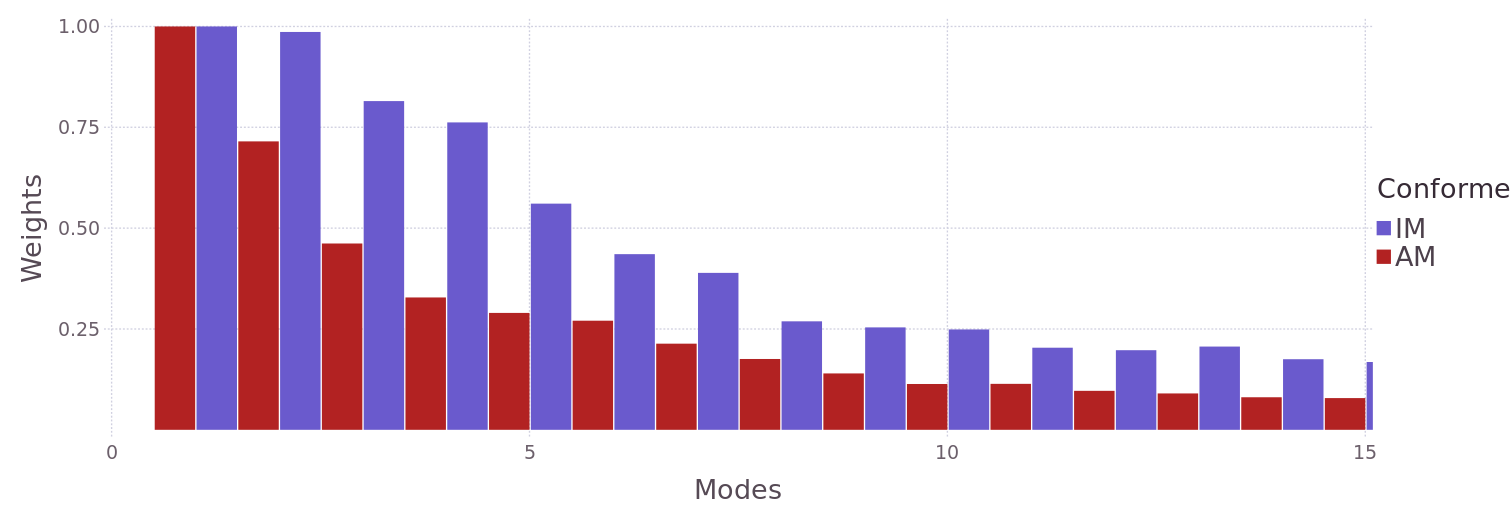

In [9]:
pdf_pesos = plot(df_pesos, x="Modes", y="Weights", color = "Conformer",
    Geom.bar(position = :dodge),

    #Guide.title("Figure 2.AA"),
    #Guide.ylabel("δV * Probability", orientation=:vertical), 
    Guide.yticks(ticks = collect(0.25:0.25:1.0)),
    Coord.cartesian(xmin = 0, xmax = 15),
    Scale.color_discrete_manual("SlateBlue","Firebrick"),


    Theme(bar_spacing = 2pt, grid_line_width=1pt, key_label_font_size = 20pt,
        minor_label_font_size = 14pt, major_label_font_size = 20pt, key_title_font_size = 20pt))

### Correlaciones entre Bfactors

In [10]:
# IM
cor_bf_im = zeros(length(im_list), length(im_list))

for i = 1:length(im_list)
    for j = i+1:length(im_list)
        cor_bf_im[j, i] = cor(bfacs_im[:, i], bfacs_im[:, j])
    end
end

# AM
cor_bf_am = zeros(length(am_list), length(am_list))

for i = 1:length(am_list)
    for j = i+1:length(am_list)
        cor_bf_am[j, i] = cor(bfacs_am[:, i], bfacs_am[:, j])
    end
end

In [11]:
# IM
vec_cor_bf_im = reshape(cor_bf_im, length(cor_bf_im))
vec_cor_bf_im = vec_cor_bf_im[vec_cor_bf_im .!= 0]

# AM
vec_cor_bf_am = reshape(cor_bf_am, length(cor_bf_am))
vec_cor_bf_am = vec_cor_bf_am[vec_cor_bf_am .!= 0]

hbins = collect(minimum(vec_cor_bf_im):0.05:maximum(vec_cor_bf_am))
hweights_im = repeat([1.0], inner = [length(vec_cor_bf_im)])
hweights_am = repeat([1.0], inner = [length(vec_cor_bf_am)])

counts_im, bins = WeightedHist(vec_cor_bf_im, hbins, hweights_im, true)
counts_am, bins = WeightedHist(vec_cor_bf_am, hbins, hweights_am, true)

df_pesos = DataFrame(Probability = [counts_am ; counts_im],
    ρ = [ bins ; bins ],
    Conformer = repeat(["AM" ; "IM"], inner = [length(bins)]));

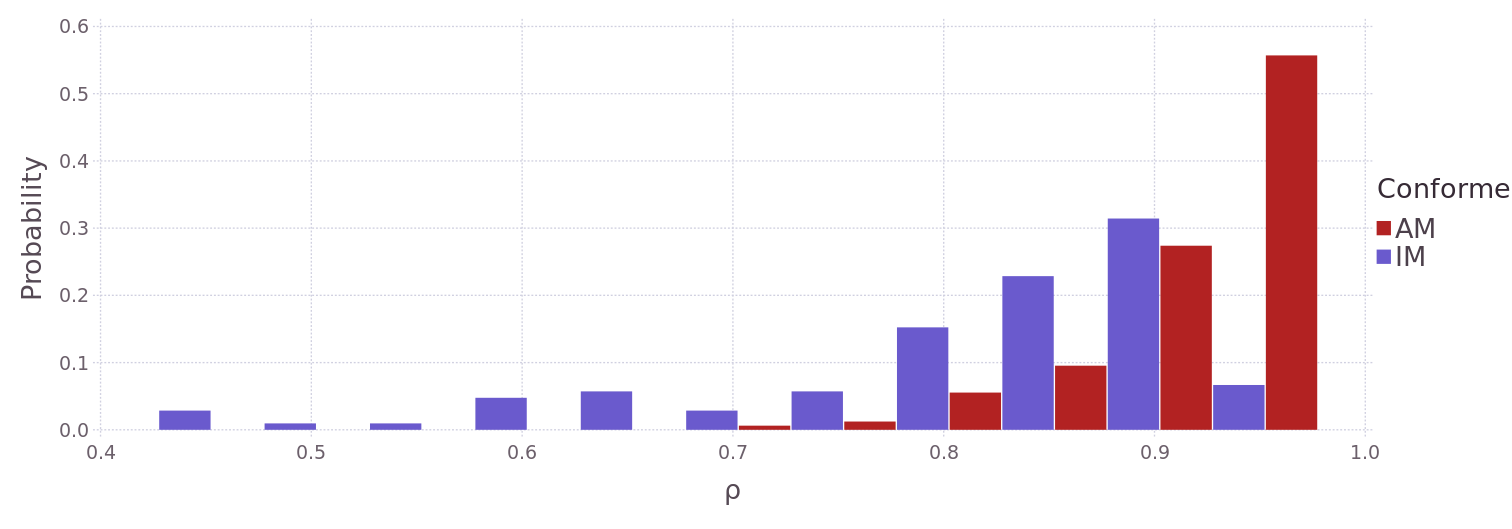

In [12]:
pdf_pesos = plot(df_pesos, x="ρ", y="Probability", color = "Conformer",
    Geom.bar(position = :dodge),

    #Guide.title("Figure 2.AA"),
    #Guide.ylabel("δV * Probability", orientation=:vertical), 
    #Guide.yticks(ticks = collect(0.25:0.25:1.0)),
    #Coord.cartesian(xmin = 0, xmax = 15),
    Scale.color_discrete_manual("Firebrick", "SlateBlue"),


    Theme(bar_spacing = 2pt, grid_line_width=1pt, key_label_font_size = 20pt,
        minor_label_font_size = 14pt, major_label_font_size = 20pt, key_title_font_size = 20pt))

## Escribo resultados de B-factors

In [13]:
# Mean B-ftors
writedlm(string(home_rtdos, "mean_bfacs_im"), mean_bfacs_im)
writedlm(string(home_rtdos, "mean_bfacs_am"), mean_bfacs_am)

# Correlación B-ftors
writedlm(string(home_rtdos, "cor_bf_im"), cor_bf_im)
writedlm(string(home_rtdos, "cor_bf_am"), cor_bf_am)

# Zeta y ND

In [12]:
im_zeta = convert(Array{Float64, 2}, readdlm(string(rehome, "zeta_im"))[2:end, :])
am_zeta = convert(Array{Float64, 2}, readdlm(string(rehome, "zeta_am"))[2:end, :]);

im_nd = convert(Array{Float64, 2}, readdlm(string(rehome, "nd_im"))[2:end, :])
am_nd = convert(Array{Float64, 2}, readdlm(string(rehome, "nd_am"))[2:end, :]);

In [13]:
tmp = reshape(im_zeta, length(im_zeta))
vec_im_zeta = tmp[tmp .!= 0.0];

tmp = reshape(am_zeta, length(am_zeta))
vec_am_zeta = tmp[tmp .!= 0.0];;

tmp = reshape(im_nd, length(im_nd))
vec_im_nd = tmp[tmp .!= 0.0];

tmp = reshape(am_nd, length(am_nd))
vec_am_nd = tmp[tmp .!= 0.0];;

In [44]:
hbins = collect(minimum(vec_im_zeta):2e-6:maximum(vec_am_zeta) - 0.00001)
hweights_im = repeat([1.0], inner = [length(vec_im_zeta)])
hweights_am = repeat([1.0], inner = [length(vec_am_zeta)])

counts_im, bins_im = WeightedHist(vec_im_zeta, hbins, hweights_im, true)
df_hist_im = DataFrame(Probability = counts_im, Zeta = bins_im)

counts_am, bins_am = WeightedHist(vec_am_zeta, hbins, hweights_am, true);
df_hist_am = DataFrame(Probability = counts_am, Zeta = bins_am);

df_zeta_hist = DataFrame(Probability = [ counts_im ; counts_am ],
    Zeta = [ bins_im ; bins_am ],
    Conformer = repeat(["IM" ; "AM"], inner = [ length(bins_im)]));

In [45]:
hbins = collect(minimum(vec_am_nd):2e-1:maximum(vec_im_nd))
hweights_im = repeat([1.0], inner = [length(vec_im_nd)])
hweights_am = repeat([1.0], inner = [length(vec_am_nd)])

counts_im, bins_im = WeightedHist(vec_im_nd, hbins, hweights_im, true)
df_hist_im = DataFrame(Probability = counts_im, nd = bins_im)

counts_am, bins_am = WeightedHist(vec_am_nd, hbins, hweights_am, true);
df_hist_am = DataFrame(Probability = counts_am, nd = bins_am);

df_nd_hist = DataFrame(Probability = [ counts_im ; counts_am ],
    ND = [ bins_im ; bins_am ],
    Conformer = repeat(["IM" ; "AM"], inner = [ length(bins_im)]));

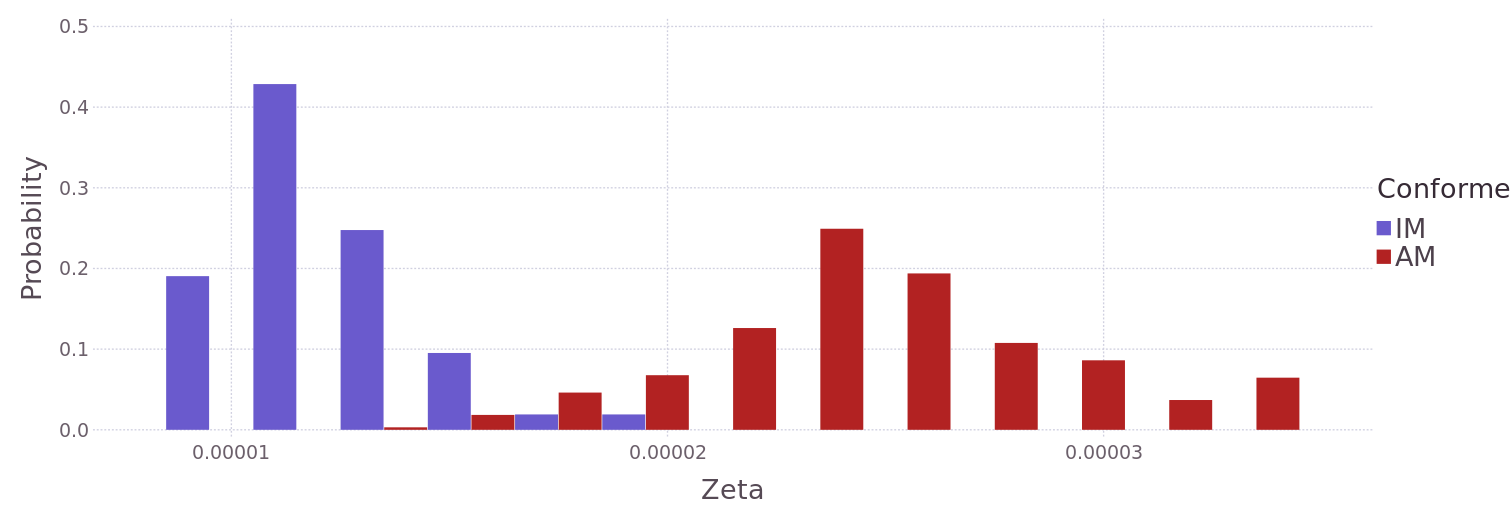

In [46]:
pdf_zeta_hist = plot(df_zeta_hist, 
    x="Zeta", y="Probability", color = "Conformer",
    Geom.bar(position = :dodge),
    Scale.color_discrete_manual("SlateBlue","Firebrick"),

    #Guide.title("Figure 2.AA"),
    #Guide.ylabel("δV * Probability", orientation=:vertical),
    Coord.cartesian(xmin = 0.000007, xmax = 0.000036),

    Theme(bar_spacing=1pt, grid_line_width=1pt, key_label_font_size = 20pt,
    minor_label_font_size = 14pt, major_label_font_size = 20pt, key_title_font_size = 20pt))

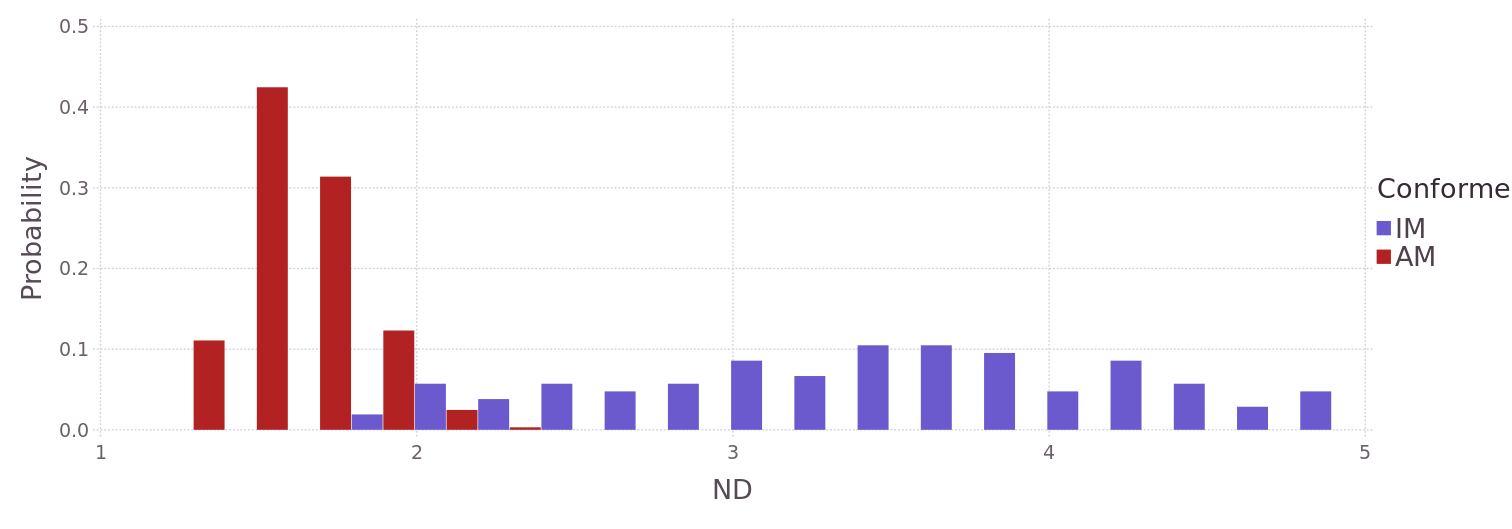

In [40]:
pdf_nd_hist = plot(df_nd_hist,
    x="ND", y="Probability", color = "Conformer",
    Geom.bar(position = :dodge),

    #Guide.title("Figure 2.AA"),
    #Guide.ylabel("δV * Probability", orientation=:vertical), 
    Coord.cartesian(xmin = 1, xmax = 5),
    Scale.color_discrete_manual("SlateBlue","Firebrick"),


    Theme(bar_spacing=1pt, grid_line_width=1pt, key_label_font_size = 20pt,
        minor_label_font_size = 14pt, major_label_font_size = 20pt, key_title_font_size = 20pt))